In [1]:
import json
import ast
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder

from config import Config, MulticlassConfig
from preprocessing import (
    build_vocab, save_vocab, load_vocab,
    build_scaler, save_scaler, load_scaler,
    build_label_encoder, save_label_encoder, load_label_encoder,
    MalwareDataset
)
from model import BiLSTM
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
ARTIFACT_DIR = "artifacts"
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.pkl")
label_ENCODER_PATH = os.path.join(ARTIFACT_DIR, "label_encoder.pkl")

In [ ]:
mode = int(input("Pilih mode (1=binary, 2=multiclass): "))

if mode == 1:
    cfg = Config()
    model_name = "binary_model.pth"
    data_files = [
        "benign.csv",
        "Malware.csv",
        ]
    file_label_map = {
        "benign.csv": 0,
        "fitur_Malware.csv": 1,
    }
    SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler_binary.pkl")
    print("Mode: binary")
elif mode == 2:
    cfg = MulticlassConfig()
    model_name = "multiclass_model.pth"
    data_files = [
        "Coinminer.csv",
        "RAT.csv",
        "Trojan.csv",
        "Cryptominer.csv",
        "Ransomware.csv"
    ]
    file_label_map = {
        fname: os.path.splitext(fname)[0].lower()
        for fname in data_files
    }
    SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler_multi.pkl")
    class_names = sorted(set(file_label_map.values()))
    le = LabelEncoder().fit(class_names)          # <— encoder string
    save_label_encoder(le, label_ENCODER_PATH)
    print("Mode: multiclass")

max_len = cfg.max_length
batch_size = cfg.batch_size
epochs = cfg.epochs
lr = cfg.learning_rate
MODEL_PATH = os.path.join(ARTIFACT_DIR, model_name)


Mode: multiclass


In [4]:
df_list = []
for fname in data_files:
    df_i = pd.read_csv(fname)
    df_i["label"] = file_label_map[fname]
    df_list.append(df_i)
df = pd.concat(df_list, ignore_index=True)

if mode == 2:
    merge_mapping = {
        "coinminer": "cryptominer",
        "rat": "trojan"
    }
    df['label'] = df['label'].replace(merge_mapping).str.lower()
    print(df['label'].value_counts())
    le = build_label_encoder(df['label'])     # <- df['label'] masih STRING
    save_label_encoder(le, label_ENCODER_PATH)
    df['y'] = le.transform(df['label'])       # 0..n-1
    cfg.num_classes = len(le.classes_)


label
trojan         239
cryptominer    163
ransomware     104
Name: count, dtype: int64


In [5]:
sequence_cols = [c for c in df.columns if c.endswith('_seq')] # Ambil kolom yang berakhiran _seq
# sequence_cols = [
#         'exec_processes_seq', 'exec_paths_seq', 'dns_queries_seq',
#         'udp_ports_seq', 'hosts_seq', 'sig_names_seq','ttps_seq','dns_types_seq',
#         'udp_ports_seq','udp_src_ports_seq', 'udp_dst_ports_seq','processes_seq',
#         'exec_paths_seq',
#     ]
for col in sequence_cols: # Konversi string ke list
    df[col] = df[col].apply(
        lambda x: ast.literal_eval(x)
                  if isinstance(x, str) and x.startswith('[')
                  else x
                  if isinstance(x, (list, np.ndarray))
                  else []
    )

df['combined_seq'] = ( # Gabungkan semua sequence columns menjadi satu string
    df[sequence_cols]
      .apply(lambda row: ";".join(str(token)
                                  for c in sequence_cols
                                  for token in row[c]), axis=1)
)

def extract_stats(s): # Fungsi untuk menghitung total, unik, dan diversity dari sequence
    toks      = s.split(';') if s else []
    total     = len(toks)
    unique    = len(set(toks))
    diversity = unique/total if total>0 else 0
    return total, unique, diversity

df[['seq_length','seq_unique_count','seq_diversity']] = ( 
    df['combined_seq']
      .apply(lambda s: pd.Series(extract_stats(s)))
)

if mode == 2:
    df['label_enc'] = LabelEncoder().fit_transform(df['label'])
else:
    classes = sorted(df['label'].unique())
    df['label_enc'] = df['label'].map({c:i for i,c in enumerate(classes)})

seq_len_df = df[sequence_cols].applymap(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)

corrs_seq = seq_len_df.corrwith(df['label_enc'])

print("Sequence columns ↔ label correlations:")
print(corrs_seq)



Sequence columns ↔ label correlations:
exec_processes_seq       0.093443
exec_paths_seq           0.093443
dns_queries_seq          0.152237
dns_types_seq            0.152237
udp_ports_seq            0.047985
udp_src_ports_seq        0.047985
udp_dst_ports_seq        0.047985
udp_sizes_seq            0.047985
udp_timestamps_seq       0.047985
hosts_seq               -0.007162
sig_names_seq           -0.325673
ttps_seq                -0.258862
processes_seq           -0.347464
process_states_seq      -0.347464
injection_flags_seq     -0.347464
parent_procid_seq       -0.347464
start_ts_seq            -0.347464
screenshot_scores_seq    0.006094
dtype: float64


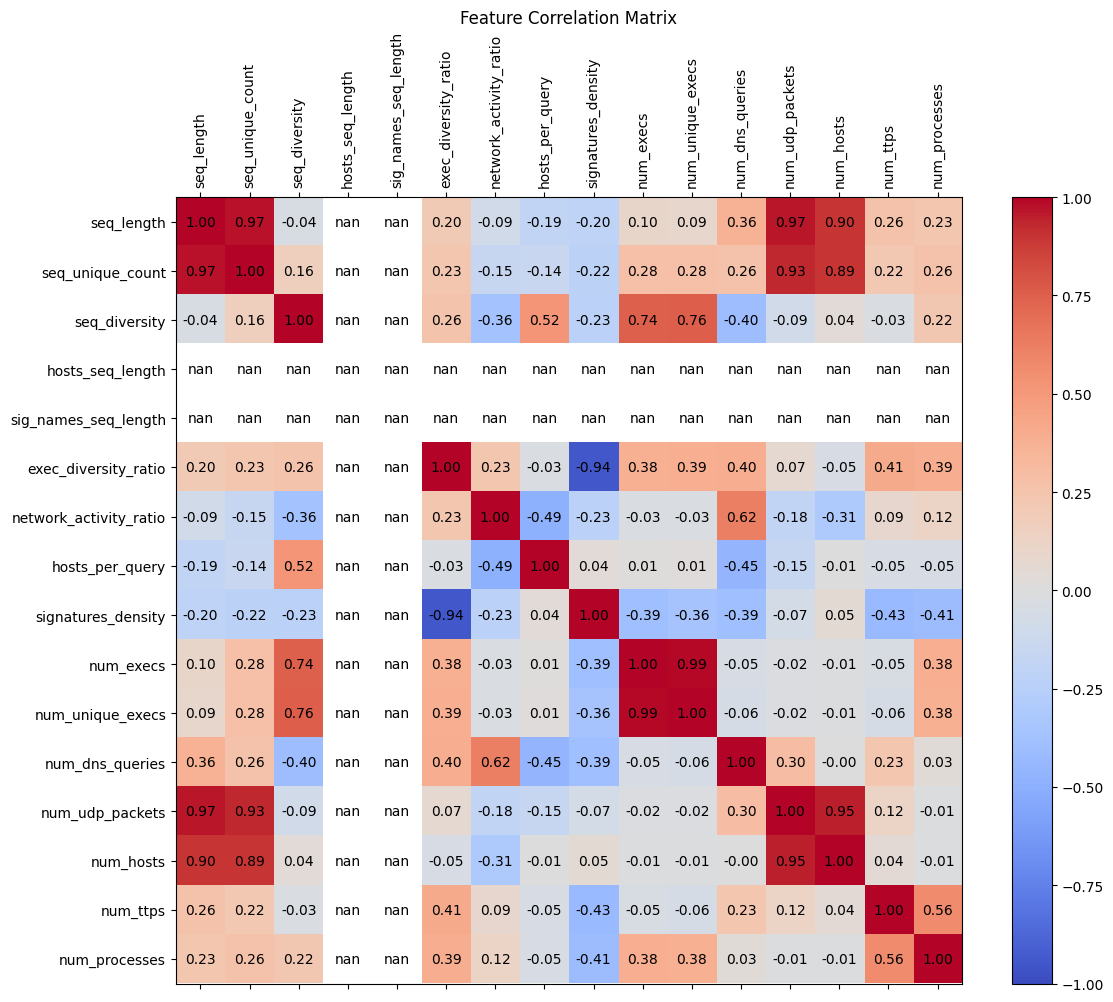

In [6]:
numeric_cols = [c for c in df.columns if c.startswith('num_')]

df[numeric_cols] = df[numeric_cols].fillna(0)

df['hosts_seq_length'] = df['hosts_seq'].astype(str).str.split(';').str.len()
df['sig_names_seq_length'] = df['sig_names_seq'].astype(str).str.split(';').str.len()

df['exec_diversity_ratio'] = df['num_unique_execs'] / (df['num_execs'] + 1)
df['network_activity_ratio'] = df['num_dns_queries'] / (df['num_udp_packets'] + 1)
df['hosts_per_query'] = df['hosts_seq_length'] / (df['num_dns_queries'] + 1)
df['signatures_density'] = df['sig_names_seq_length'] / (df['num_execs'] + 1)

feat_cols = ['seq_length', 'seq_unique_count', 'seq_diversity','hosts_seq_length','sig_names_seq_length',
             'exec_diversity_ratio','network_activity_ratio','hosts_per_query','signatures_density'] + numeric_cols

# Compute correlation matrix
corr_matrix = df[feat_cols].corr()

# Plot heatmap with annotations and diverging colormap
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

# Annotate each cell with its correlation value
for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

# Label axes with feature names
ax.set_xticks(np.arange(len(feat_cols)))
ax.set_xticklabels(feat_cols, rotation=90)
ax.set_yticks(np.arange(len(feat_cols)))
ax.set_yticklabels(feat_cols)

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [7]:
if mode == 1:
    selected_features = [
        'num_unique_execs', 'num_dns_queries', 
        'network_activity_ratio', 'hosts_per_query',
        "num_execs",
        'hosts_seq_length',
        "num_hosts",
        "num_ttps",
        "num_processes",
        "exec_diversity_ratio",
        "network_activity_ratio",
        "seq_length",
        "seq_unique_count",
        "sig_names_seq_length",
        "signatures_density",
        'num_udp_packets',
    ]


    # Drop the rest (redundan atau engineered)
    features_to_drop = [

    ]


else:
    selected_features = [
        "seq_diversity",          # statistik sequence yang paling beda sendiri 
        "num_execs",              # wakil cluster eksekusi (num_unique_execs & num_processes mirip)
        "num_dns_queries",        # wakil cluster network (DNS vs UDP; pilih satu)
        "num_hosts",              # host diversity, korelasi moderat
        "num_ttps",
        "seq_length",
        "seq_unique_count",
        "hosts_seq_length",
        "sig_names_seq_length",
        "exec_diversity_ratio",
        "hosts_per_query",
        "signatures_density",
        "num_unique_execs",
        "num_udp_packets",
        "num_processes",
        "network_activity_ratio",              # paling independen di numeric (TTP coverage)
    ]
    features_to_drop = [

    ]


# Update numeric_cols for training
numeric_cols = selected_features
seqs = []
labels = []  # <- TAMBAH INI

for _, row in df.iterrows():
    parts = []
    for col in sequence_cols:
        try:
            col_data = row[col]
            if col_data is not None and str(col_data) != "nan":
                if isinstance(col_data, str):
                    parts.extend(col_data.split(';'))
                else:
                    # Handle list/array
                    parts.extend([str(x) for x in col_data])
        except:
            continue
    
    seqs.append(';'.join(parts))
    labels.append(row['label_enc'])  # <- TAMBAH INI (sesuaikan nama kolom label)
# for _, row in df.iterrows():
#     parts = []
#     for col in sequence_cols:
#         parts.extend(map(str, row[col]))
#     seqs.append(";".join(parts))
# labels = df['label_enc'].tolist()

print(f"Selected features ({len(selected_features)}): {selected_features}")
print(f"Dropped features ({len(features_to_drop)}): {features_to_drop}")
print("="*50)

cfg.numeric_dim = len(selected_features)
print(f"Updated numeric_dim to: {cfg.numeric_dim}")

Selected features (16): ['seq_diversity', 'num_execs', 'num_dns_queries', 'num_hosts', 'num_ttps', 'seq_length', 'seq_unique_count', 'hosts_seq_length', 'sig_names_seq_length', 'exec_diversity_ratio', 'hosts_per_query', 'signatures_density', 'num_unique_execs', 'num_udp_packets', 'num_processes', 'network_activity_ratio']
Dropped features (0): []
Updated numeric_dim to: 16


In [8]:
nums = df[numeric_cols].fillna(0).values

s_tr, s_te, n_tr, n_te, y_tr, y_te = train_test_split(
    seqs, nums, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

s_tr, s_val, n_tr, n_val, y_tr, y_val = train_test_split(
    s_tr, n_tr, y_tr,
    test_size=0.1,
    random_state=42,
    stratify=y_tr
)

In [9]:
if mode == 1:   # BINARY
    vocab  = build_vocab(s_tr)
    save_vocab(vocab, VOCAB_PATH)

    scaler = build_scaler(n_tr)
    save_scaler(scaler, SCALER_PATH)

    # pos_weight untuk BCEWithLogitsLoss
    cnt = np.bincount(y_tr, minlength=2)          # [neg, pos]
    pos_weight = torch.tensor([cnt[0] / cnt[1]],  # shape [1]
                              dtype=torch.float32, device=cfg.device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

else:           # MULTICLASS
    scaler = build_scaler(n_tr)
    save_scaler(scaler, SCALER_PATH)

    le = load_label_encoder(label_ENCODER_PATH)   # sudah fit ke string
    num_classes = cfg.num_classes                 # 3 sekarang
    classes = np.arange(num_classes)              # [0,1,2]

    cw = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_tr
    )
    class_weights_tensor = torch.tensor(cw, dtype=torch.float32).to(cfg.device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print("Expected classes from config:", cfg.num_classes)
if mode == 2:
    print("Class weights shape:", class_weights_tensor.shape, "->", class_weights_tensor)


Expected classes from config: 3
Class weights shape: torch.Size([3]) -> tensor([1.0342, 1.6351, 0.7035])


In [10]:
vocab = load_vocab(VOCAB_PATH)
scaler = load_scaler(SCALER_PATH)
le = load_label_encoder(label_ENCODER_PATH)

train_ds = MalwareDataset(s_tr, n_tr, y_tr, vocab, scaler, le, cfg.max_length)
val_ds   = MalwareDataset(s_val, n_val, y_val, vocab, scaler, le, cfg.max_length)
test_ds  = MalwareDataset(s_te, n_te, y_te, vocab, scaler, le, cfg.max_length)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size)

print(f"Datasets → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

Datasets → train: 363, val: 41, test: 102


In [11]:
device = cfg.device
model = BiLSTM(vocab_size=len(vocab), cfg=cfg).to(cfg.device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

In [12]:
best_val_acc = 0.0
for ep in range(epochs):
    model.train()
    train_loss = correct = total = 0
    for batch in train_loader:
        seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
        seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

        optimizer.zero_grad()
        logits = model(seq, nums)
        loss = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * seq.size(0)
        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:,1]
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)
        correct   += (preds == lbl).sum().item()
        total     += seq.size(0)

    train_loss /= total
    train_acc   = 100 * correct / total

    # Validation
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for batch in val_loader:                # ← pakai val_loader
            seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
            seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

            logits = model(seq, nums)
            loss = criterion(logits, lbl)
            val_loss += loss.item() * seq.size(0)

            # untuk binary, threshold, kalau multiclass argmax
            if cfg.num_classes == 2:
                probs = torch.softmax(logits, dim=1)[:,1]
                preds = (probs > cfg.threshold).long()
            else:
                preds = logits.argmax(dim=1)

            correct += (preds == lbl).sum().item()
            total   += seq.size(0)

    val_loss /= total
    val_acc   = 100 * correct / total

    print(f"Epoch {ep+1}/{epochs} | Train: {train_acc:.1f}% ({train_loss:.4f}) | Val: {val_acc:.1f}% ({val_loss:.4f})")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        tag = "Binary" if cfg.num_classes==2 else "Multiclass"
        print(f"{tag} model saved to '{ARTIFACT_DIR}/' folder (best so far)")

Epoch 1/20 | Train: 52.9% (1.0588) | Val: 51.2% (0.9689)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 2/20 | Train: 51.8% (0.9141) | Val: 65.9% (0.8478)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 3/20 | Train: 64.7% (0.7792) | Val: 61.0% (0.7460)
Epoch 4/20 | Train: 67.2% (0.7083) | Val: 61.0% (0.7862)
Epoch 5/20 | Train: 66.9% (0.7148) | Val: 63.4% (0.7737)
Epoch 6/20 | Train: 71.9% (0.6893) | Val: 68.3% (0.7451)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 7/20 | Train: 73.3% (0.6516) | Val: 75.6% (0.7378)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 8/20 | Train: 71.9% (0.6413) | Val: 73.2% (0.7395)
Epoch 9/20 | Train: 73.8% (0.6089) | Val: 70.7% (0.7413)
Epoch 10/20 | Train: 74.4% (0.5956) | Val: 70.7% (0.7503)
Epoch 11/20 | Train: 76.9% (0.5937) | Val: 73.2% (0.7639)
Epoch 12/20 | Train: 71.9% (0.5820) | Val: 75.6% (0.7739)
Epoch 13/20 | Train: 77.7% (0.5547) | Val: 70.7% (0.7862)
Epoch 14/20 | T

In [13]:
print(f"Training done! Best Val accuracy: {best_val_acc:.1f}%")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Training done! Model saved to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Training done! Best Val accuracy: 75.6%
Training done! Model saved to artifacts\multiclass_model.pth
Model saved to artifacts\multiclass_model.pth


- Dataset size: 102
- Collected preds: 102, labels: 102

Test Accuracy : 77.45%
Test F1-macro : 0.7365


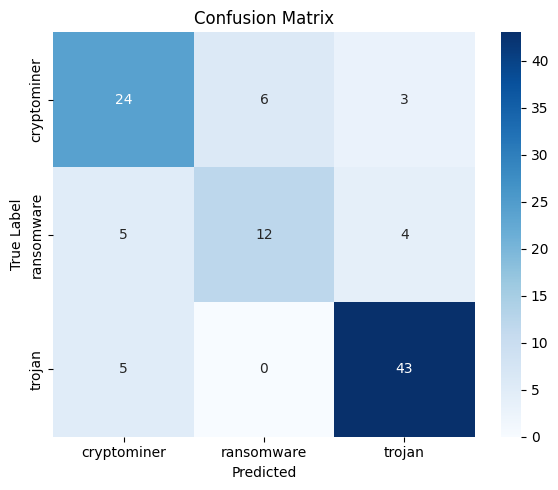


Classification Report:
              precision    recall  f1-score   support

 cryptominer       0.71      0.73      0.72        33
  ransomware       0.67      0.57      0.62        21
      trojan       0.86      0.90      0.88        48

    accuracy                           0.77       102
   macro avg       0.74      0.73      0.74       102
weighted avg       0.77      0.77      0.77       102



In [14]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        seq = batch["sequence"].to(device)
        num = batch["numeric"].to(device)
        lbl = batch["label"].to(device)

        logits = model(seq, num) if hasattr(model, "classifier") else model(seq)

        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)

        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(lbl.cpu().numpy())

print(f"- Dataset size: {len(test_loader.dataset)}")
print(f"- Collected preds: {len(all_preds)}, labels: {len(all_labels)}")

acc      = accuracy_score(all_labels, all_preds) * 100
f1_macro = f1_score(all_labels, all_preds, average="macro")
print(f"\nTest Accuracy : {acc:.2f}%")
print(f"Test F1-macro : {f1_macro:.4f}")

cm = confusion_matrix(all_labels, all_preds)
names = (le.classes_ if cfg.num_classes > 2 else ["benign","malware"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=names))

In [15]:
# Quick debug - tambah print di awal evaluate_model
for batch in test_loader:
    seq = batch["sequence"]
    nums = batch["numeric"] 
    labels = batch["label"]
    
    print(f"seq shape: {seq.shape}")
    print(f"nums shape: {nums.shape}")  # <- ini yang penting
    print(f"labels shape: {labels.shape}")
    break

seq shape: torch.Size([64, 80])
nums shape: torch.Size([64, 16])
labels shape: torch.Size([64])


1. Single Feature Ablation
Starting Feature Ablation Study...
Baseline Accuracy: 0.7745
------------------------------
Testing without feature_0...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_1...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_2...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_3...
  Accuracy: 0.7157
  Importance: 0.0588

Testing without feature_4...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_5...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_6...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_7...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_8...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_9...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_10...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_11...
  Accuracy: 0.7745
  Importance: 0.0000

Testing without feature_12...
  Accurac

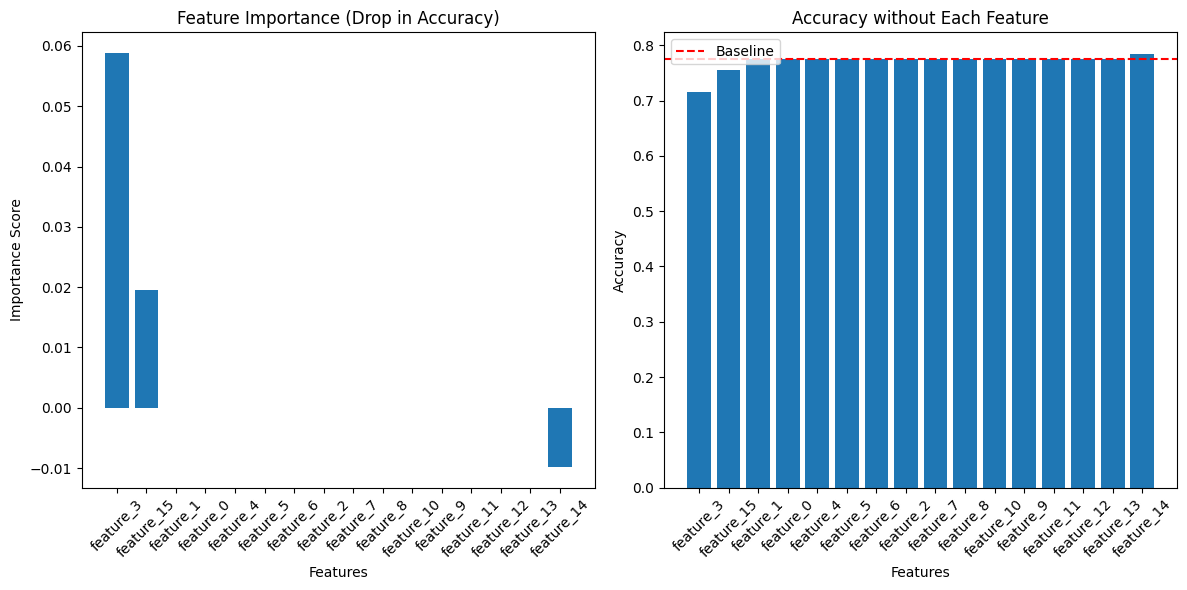


2. Progressive Ablation
Starting Progressive Ablation...
Step 1: Removed feature_14
  Accuracy: 0.7843
  Remaining: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_15']

Step 2: Removed feature_1
  Accuracy: 0.7843
  Remaining: ['feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_15']

Step 3: Removed feature_6
  Accuracy: 0.7843
  Remaining: ['feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_15']

Step 4: Removed feature_7
  Accuracy: 0.7843
  Remaining: ['feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature

In [16]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

class FeatureAblationStudy:
    def __init__(self, model, test_loader, device, cfg, feature_names=None):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.cfg = cfg
        self.num_features = cfg.numeric_dim
        self.feature_names = feature_names or [f'feature_{i}' for i in range(self.num_features)]
        
    def evaluate_model(self, data_loader, ablate_feature=None):
        """Evaluate model dengan atau tanpa ablation"""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                # Unpack dictionary batch
                seq = batch["sequence"].to(self.device)
                nums = batch["numeric"].to(self.device)  # shape: (batch, max_length, numeric_dim)
                labels = batch["label"].to(self.device)
                
                # Apply ablation jika diperlukan
                if ablate_feature is not None:
                    nums_ablated = nums.clone()
                    # Handle different tensor dimensions
                    if nums.dim() == 3:  # (batch, seq_len, features)
                        nums_ablated[:, :, ablate_feature] = 0
                    elif nums.dim() == 2:  # (batch, features) - flattened
                        nums_ablated[:, ablate_feature] = 0
                    else:
                        raise ValueError(f"Unexpected nums tensor dimension: {nums.dim()}")
                    outputs = self.model(seq, nums_ablated)
                else:
                    outputs = self.model(seq, nums)
                
                # Untuk binary classification
                if outputs.shape[-1] == 1:
                    preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                # Untuk multiclass
                else:
                    preds = torch.argmax(outputs, dim=-1).cpu().numpy()
                
                all_preds.extend(preds.flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        
        accuracy = accuracy_score(all_labels, all_preds)
        return accuracy, all_preds, all_labels
    
    def run_ablation_study(self):
        """Jalankan ablation study untuk semua fitur"""
        print("Starting Feature Ablation Study...")
        print("="*50)
        
        # Baseline performance (tanpa ablation)
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        print(f"Baseline Accuracy: {baseline_acc:.4f}")
        print("-"*30)
        
        results = {
            'feature': ['baseline'],
            'accuracy': [baseline_acc],
            'importance_score': [0.0]
        }
        
        # Test setiap fitur
        for feature_idx in range(self.num_features):
            print(f"Testing without {self.feature_names[feature_idx]}...")
            
            # Evaluate tanpa fitur ini
            ablated_acc, _, _ = self.evaluate_model(
                self.test_loader, 
                ablate_feature=feature_idx
            )
            
            # Hitung importance score (penurunan akurasi)
            importance = baseline_acc - ablated_acc
            
            results['feature'].append(self.feature_names[feature_idx])
            results['accuracy'].append(ablated_acc)
            results['importance_score'].append(importance)
            
            print(f"  Accuracy: {ablated_acc:.4f}")
            print(f"  Importance: {importance:.4f}")
            print()
        
        return pd.DataFrame(results)
    
    def run_progressive_ablation(self):
        """Progressive ablation - hapus fitur satu per satu"""
        print("Starting Progressive Ablation...")
        print("="*50)
        
        remaining_features = list(range(self.num_features))
        removed_features = []
        results = []
        
        # Baseline
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        results.append({
            'step': 0,
            'removed_features': [],
            'remaining_features': remaining_features.copy(),
            'accuracy': baseline_acc
        })
        
        while len(remaining_features) > 1:
            best_to_remove = None
            best_accuracy = -1
            
            # Test menghilangkan setiap fitur yang tersisa
            for feature_idx in remaining_features:
                test_features = [f for f in remaining_features if f != feature_idx]
                
                # Create custom data loader dengan fitur yang di-mask
                masked_acc = self._evaluate_with_masked_features(
                    self.test_loader, 
                    keep_features=test_features
                )
                
                if masked_acc > best_accuracy:
                    best_accuracy = masked_acc
                    best_to_remove = feature_idx
            
            # Remove fitur dengan impact paling kecil
            remaining_features.remove(best_to_remove)
            removed_features.append(best_to_remove)
            
            results.append({
                'step': len(removed_features),
                'removed_feature': self.feature_names[best_to_remove],
                'remaining_features': [self.feature_names[f] for f in remaining_features],
                'accuracy': best_accuracy
            })
            
            print(f"Step {len(removed_features)}: Removed {self.feature_names[best_to_remove]}")
            print(f"  Accuracy: {best_accuracy:.4f}")
            print(f"  Remaining: {[self.feature_names[f] for f in remaining_features]}")
            print()
        
        return results
    
    def _evaluate_with_masked_features(self, data_loader, keep_features):
        """Helper untuk evaluate dengan hanya fitur tertentu"""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                # Unpack dictionary batch
                seq = batch["sequence"].to(self.device)
                nums = batch["numeric"].to(self.device)
                labels = batch["label"].to(self.device)
                
                # Mask semua fitur kecuali yang di keep_features
                nums_masked = torch.zeros_like(nums)
                for feature_idx in keep_features:
                    if nums.dim() == 3:  # (batch, seq_len, features)
                        nums_masked[:, :, feature_idx] = nums[:, :, feature_idx]
                    elif nums.dim() == 2:  # (batch, features)
                        nums_masked[:, feature_idx] = nums[:, feature_idx]
                
                outputs = self.model(seq, nums_masked)
                
                if outputs.shape[-1] == 1:
                    preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                else:
                    preds = torch.argmax(outputs, dim=-1).cpu().numpy()
                
                all_preds.extend(preds.flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        
        return accuracy_score(all_labels, all_preds)
    
    def plot_results(self, results_df):
        """Plot hasil ablation study"""
        import matplotlib.pyplot as plt
        
        # Sort by importance score
        results_sorted = results_df[results_df['feature'] != 'baseline'].sort_values(
            'importance_score', ascending=False
        )
        
        plt.figure(figsize=(12, 6))
        
        # Bar plot importance scores
        plt.subplot(1, 2, 1)
        plt.bar(results_sorted['feature'], results_sorted['importance_score'])
        plt.title('Feature Importance (Drop in Accuracy)')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.xticks(rotation=45)
        
        # Accuracy comparison
        plt.subplot(1, 2, 2)
        plt.bar(results_sorted['feature'], results_sorted['accuracy'])
        plt.axhline(y=results_df[results_df['feature'] == 'baseline']['accuracy'].iloc[0], 
                   color='r', linestyle='--', label='Baseline')
        plt.title('Accuracy without Each Feature')
        plt.xlabel('Features')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Usage example:
def run_ablation_analysis(model, test_loader, cfg):
    """Main function untuk menjalankan ablation study"""
    
    # Define nama fitur sesuai cfg.numeric_dim
    feature_names = [f'feature_{i}' for i in range(cfg.numeric_dim)]
    # Atau bisa custom names:
    # feature_names = ['price', 'volume', 'sentiment', 'trend', 'volatility']  # contoh
    
    # Initialize ablation study
    ablation = FeatureAblationStudy(
        model=model,
        test_loader=test_loader,
        device=cfg.device,
        cfg=cfg,
        feature_names=feature_names
    )
    
    # Run single feature ablation
    print("1. Single Feature Ablation")
    results_df = ablation.run_ablation_study()
    
    # Print results
    print("\nRESULTS SUMMARY:")
    print("="*50)
    print(results_df.to_string(index=False))
    
    # Find most important features
    important_features = results_df[results_df['feature'] != 'baseline'].nlargest(3, 'importance_score')
    print(f"\nTop 3 Most Important Features:")
    for _, row in important_features.iterrows():
        print(f"  {row['feature']}: {row['importance_score']:.4f}")
    
    # Plot results
    ablation.plot_results(results_df)
    
    # Optional: Run progressive ablation
    print("\n2. Progressive Ablation")
    progressive_results = ablation.run_progressive_ablation()
    
    return results_df, progressive_results

# Cara pakai:
results, progressive = run_ablation_analysis(model, test_loader, cfg)